In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta

In [9]:
df = pd.read_csv(r"C:\Users\91965\Desktop\Project File\stock_data.csv")
df

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2023-07-03,HDFCBANK.NS,1696.631836,1719.800049,1757.500000,1710.000000,1712.500000,22052058.0
1,2023-07-03,INFY.NS,1309.278564,1333.699951,1346.000000,1328.449951,1330.000000,7732412.0
2,2023-07-03,RELIANCE.NS,2405.791992,2414.290283,2420.105225,2358.587158,2361.079346,6077193.0
3,2023-07-03,TCS.NS,3216.993164,3272.300049,3318.800049,3268.750000,3314.300049,1687264.0
4,2023-07-04,HDFCBANK.NS,1704.918579,1728.199951,1747.000000,1713.800049,1723.449951,19397594.0
...,...,...,...,...,...,...,...,...
967,2024-06-27,TCS.NS,3934.149902,3934.149902,3942.000000,3818.100098,3831.000000,4526556.0
968,2024-06-28,HDFCBANK.NS,1683.800049,1683.800049,1706.599976,1679.000000,1697.599976,13238023.0
969,2024-06-28,INFY.NS,1566.750000,1566.750000,1588.500000,1564.250000,1572.550049,8197544.0
970,2024-06-28,RELIANCE.NS,3130.800049,3130.800049,3162.000000,3062.050049,3062.050049,14478668.0


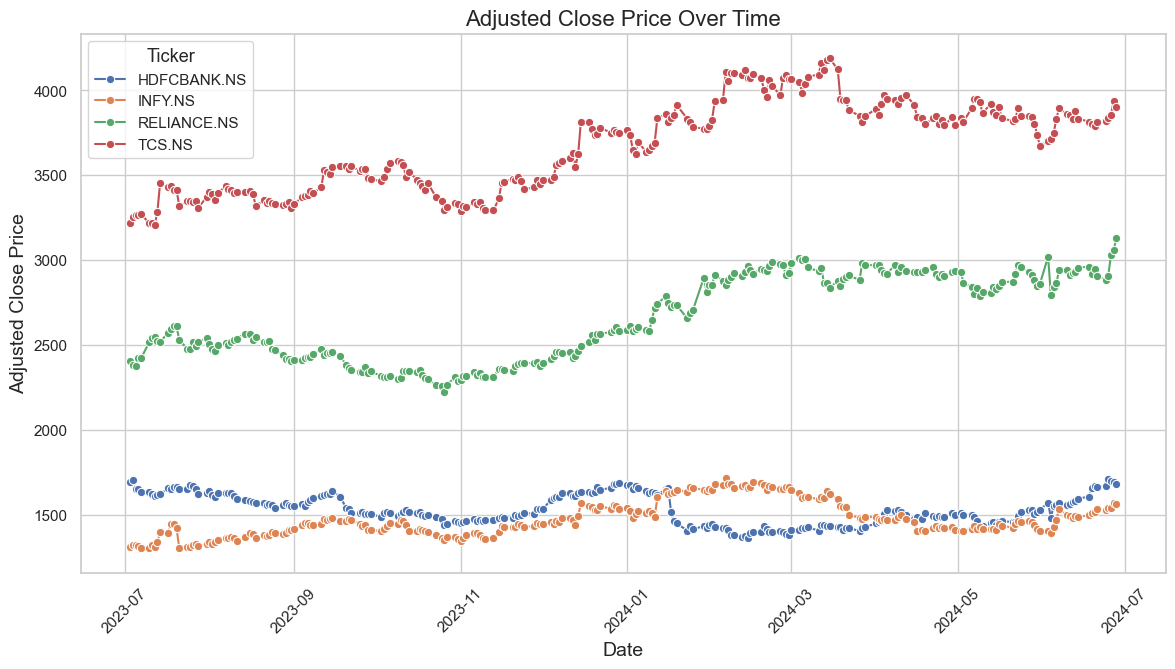

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

plt.figure(figsize = (14,7))
sns.set(style = 'whitegrid')

sns.lineplot(data = df, x='Date', y='Adj Close', hue='Ticker', marker = 'o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

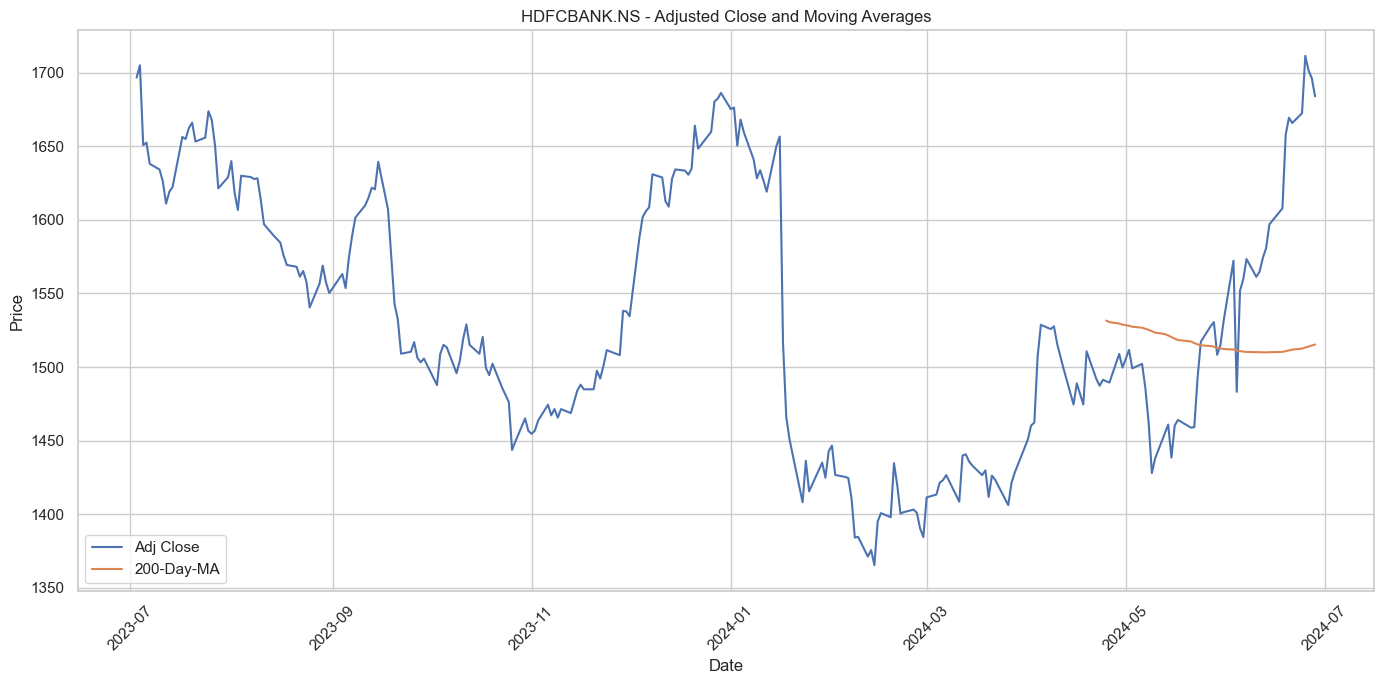

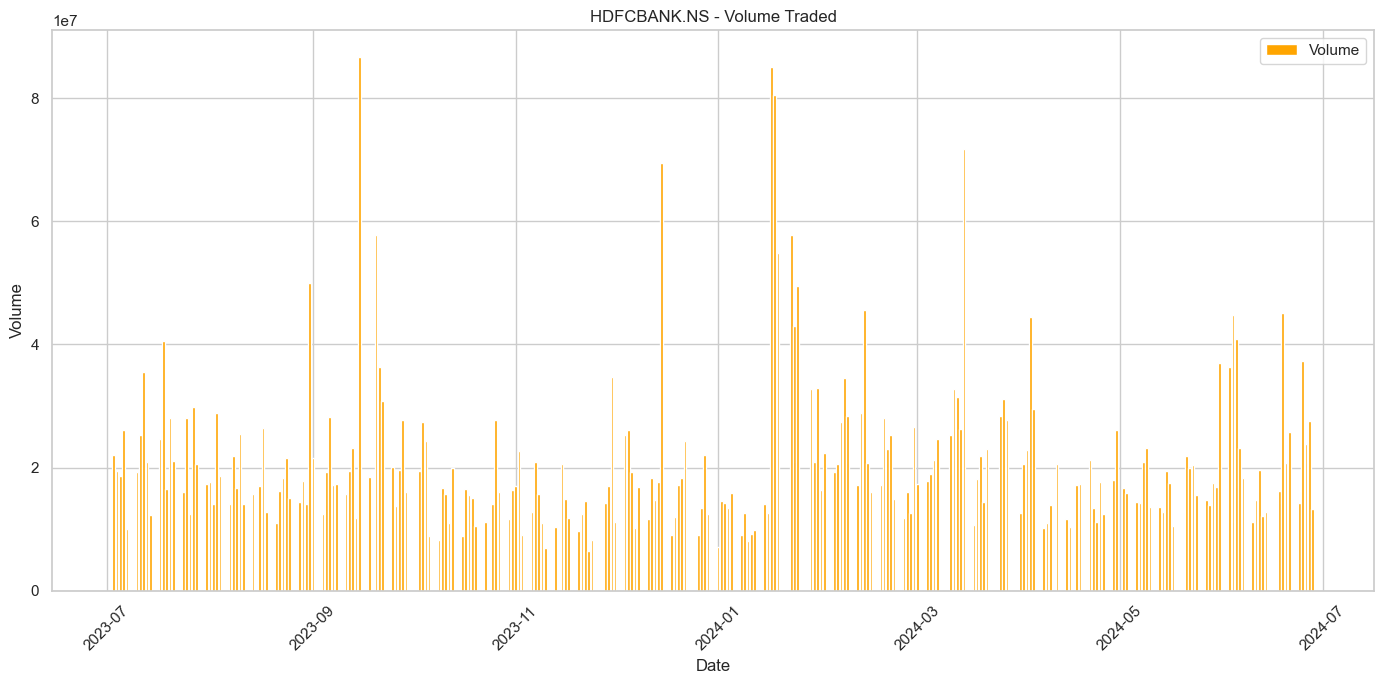

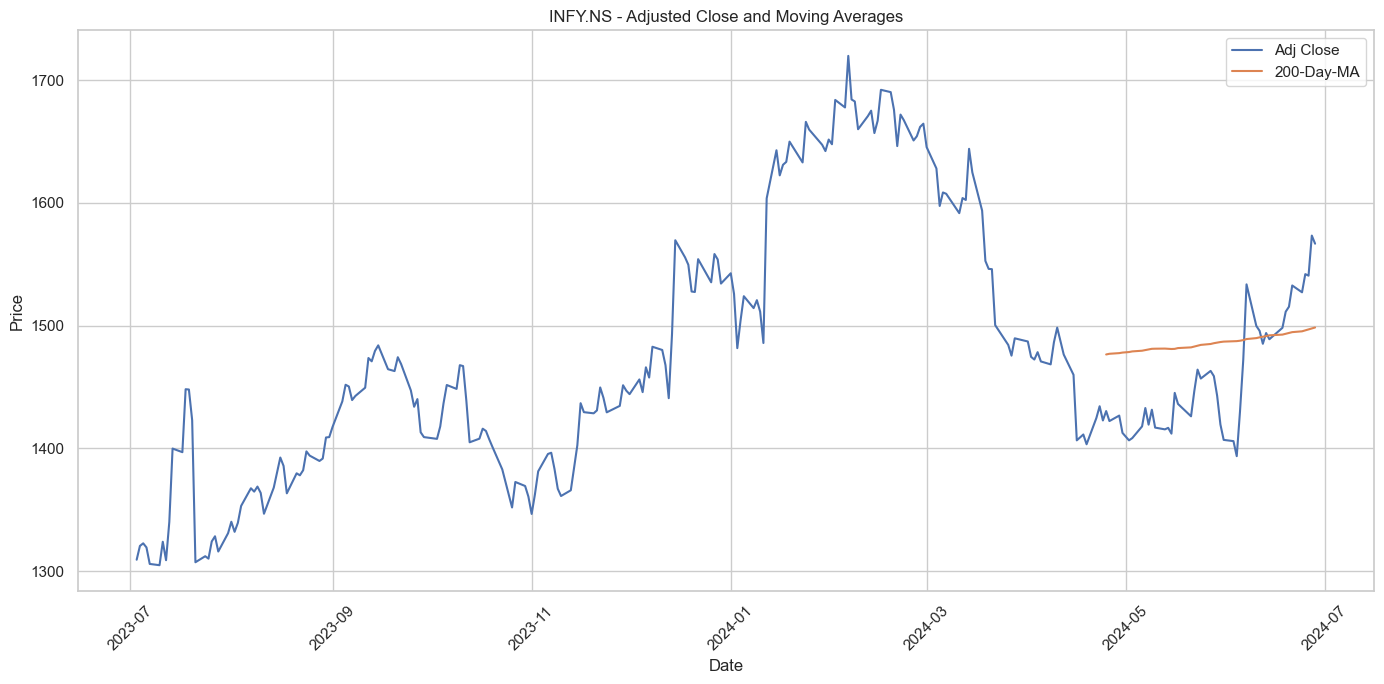

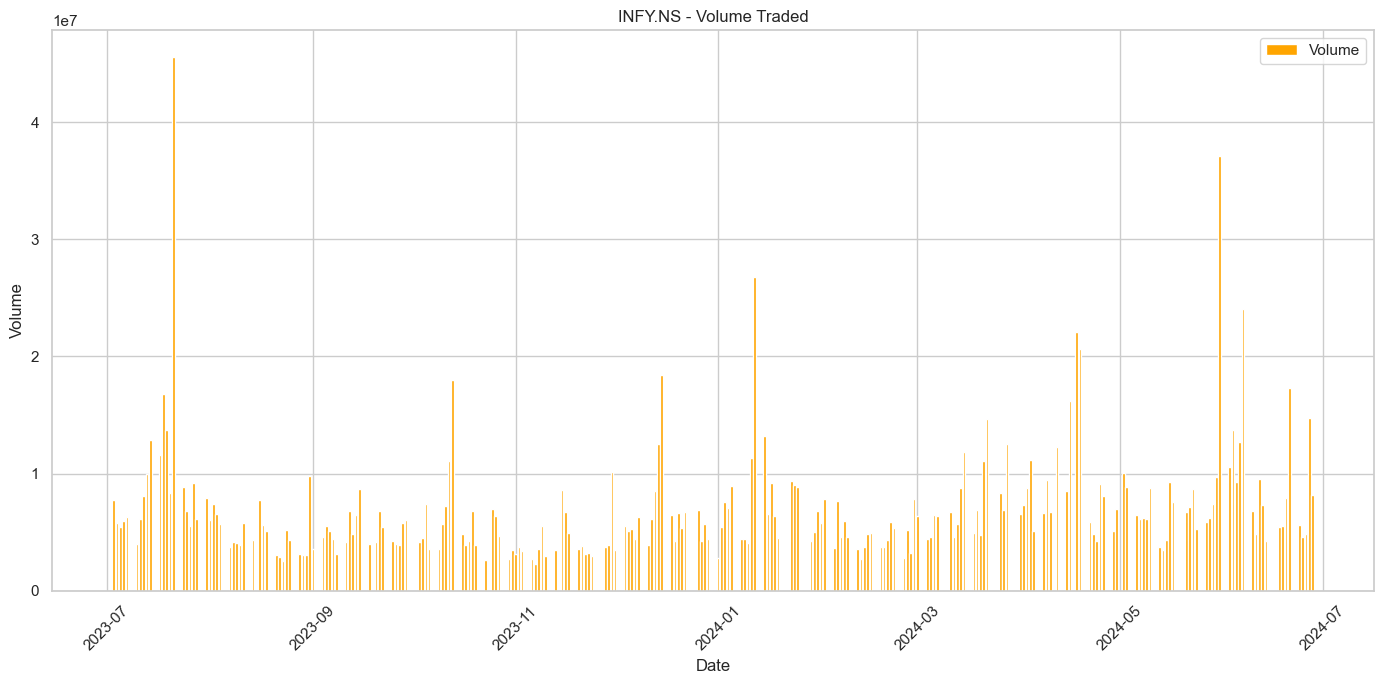

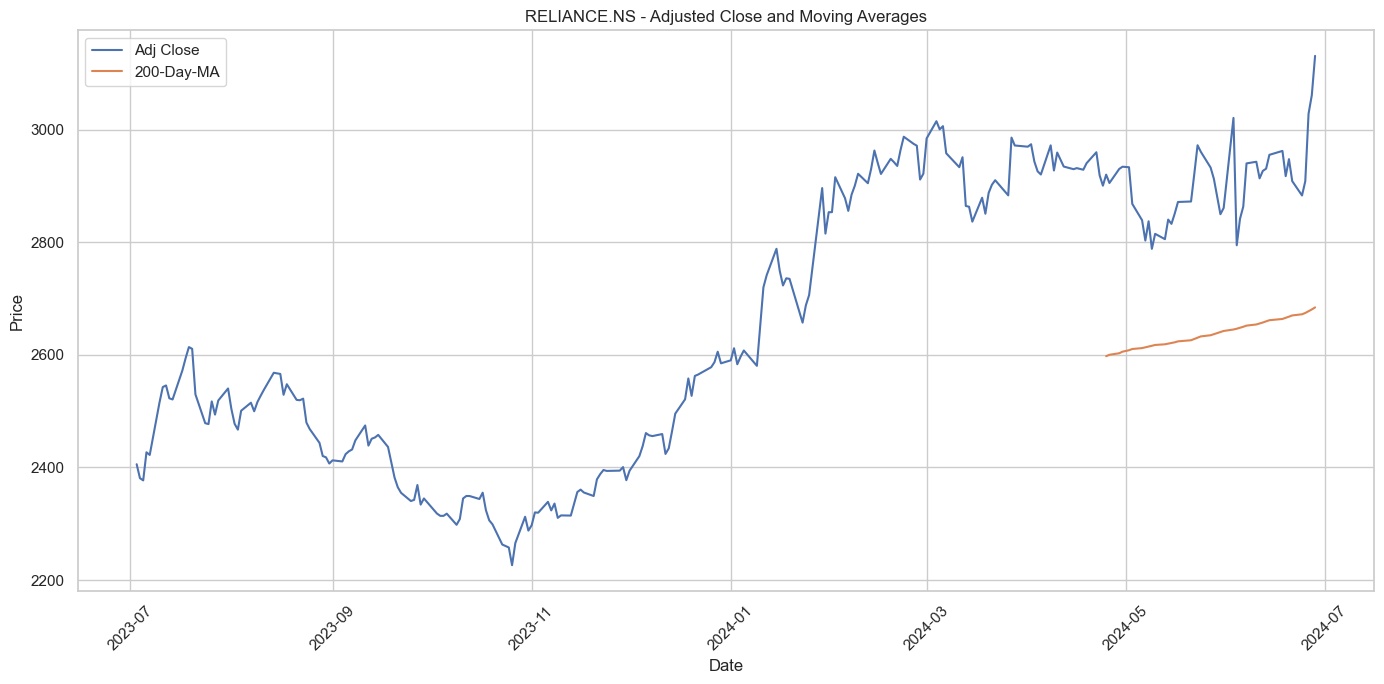

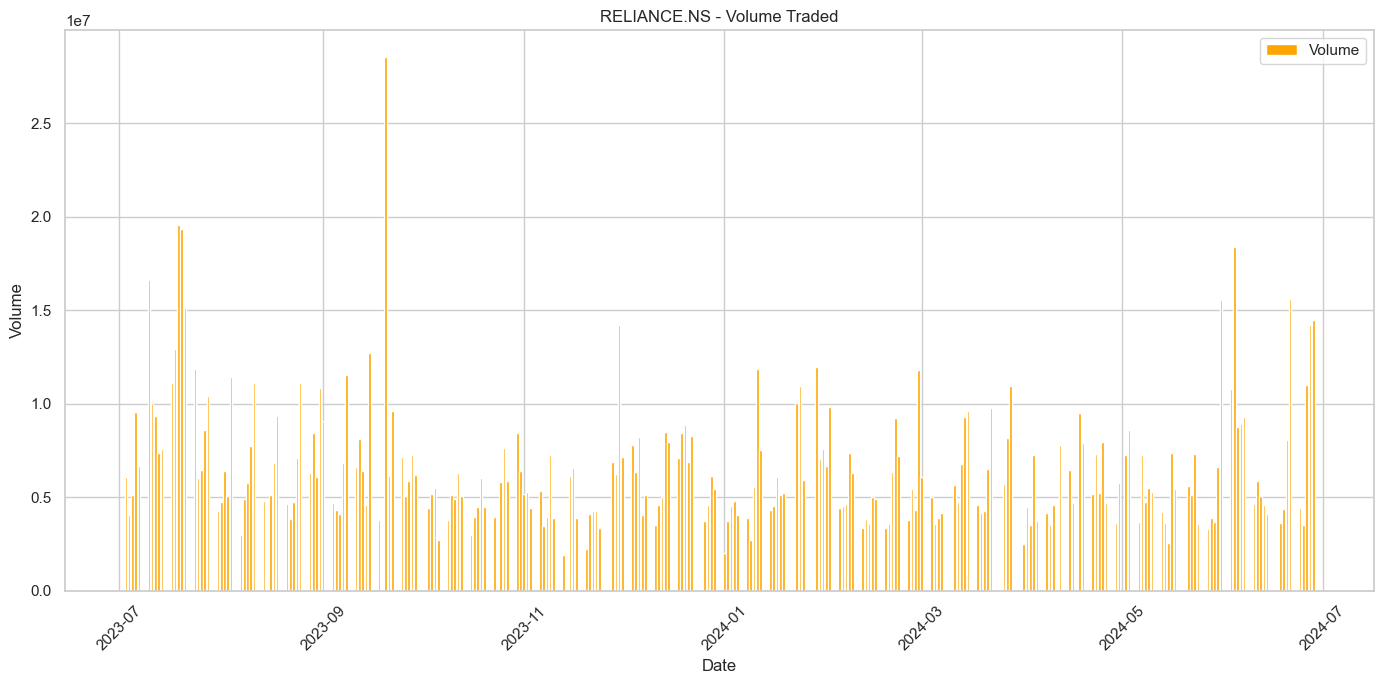

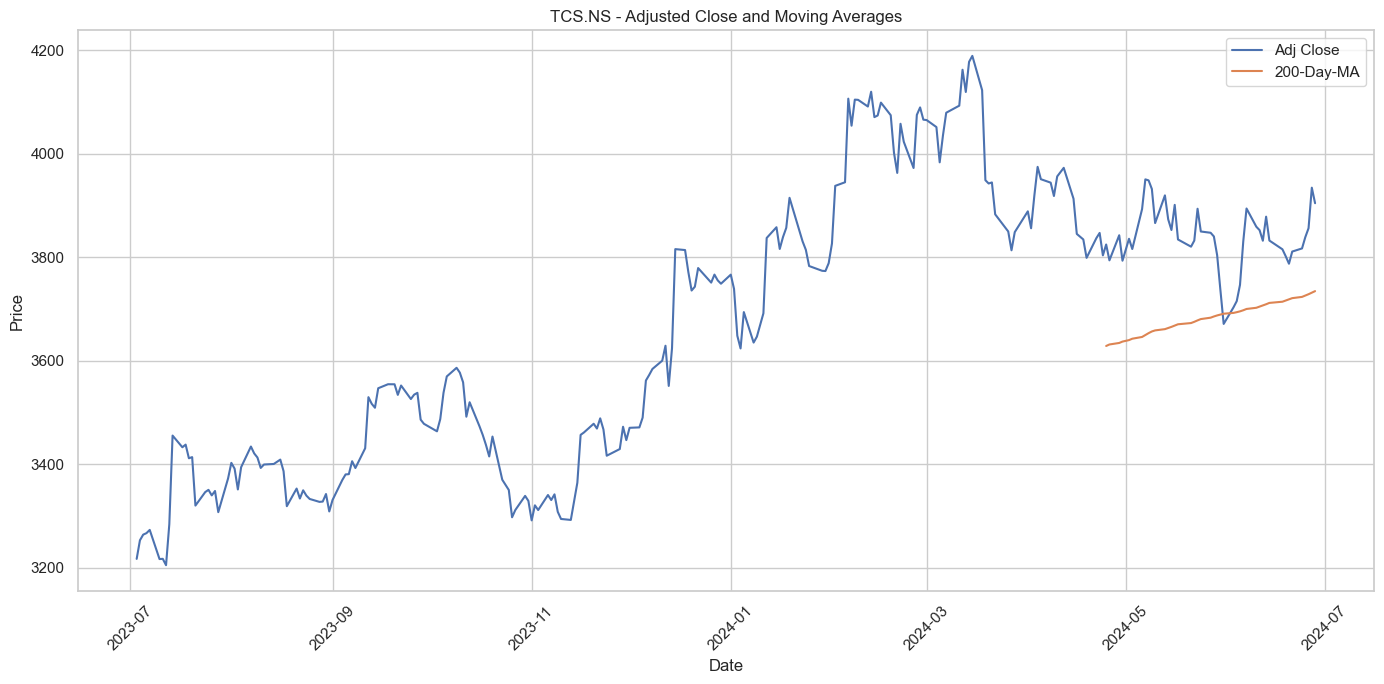

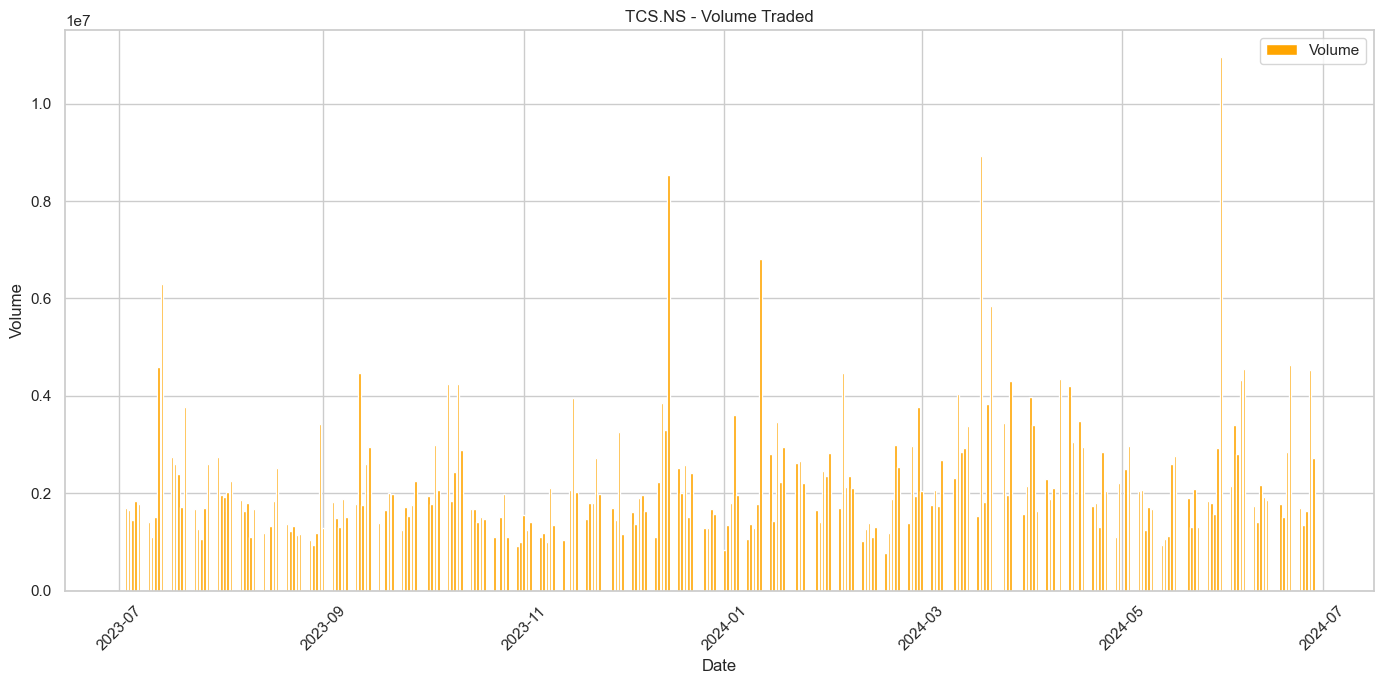

In [16]:
short_window = 50
long_window = 200


df_tickers = df['Ticker'].unique()

for ticker in df_tickers:
    ticker_data = df[df['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window = short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window = long_window).mean()
    
    plt.figure(figsize = (14,7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label = 'Adj Close')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label = '200-Day-MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (14,7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label = 'Volume', color = 'orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

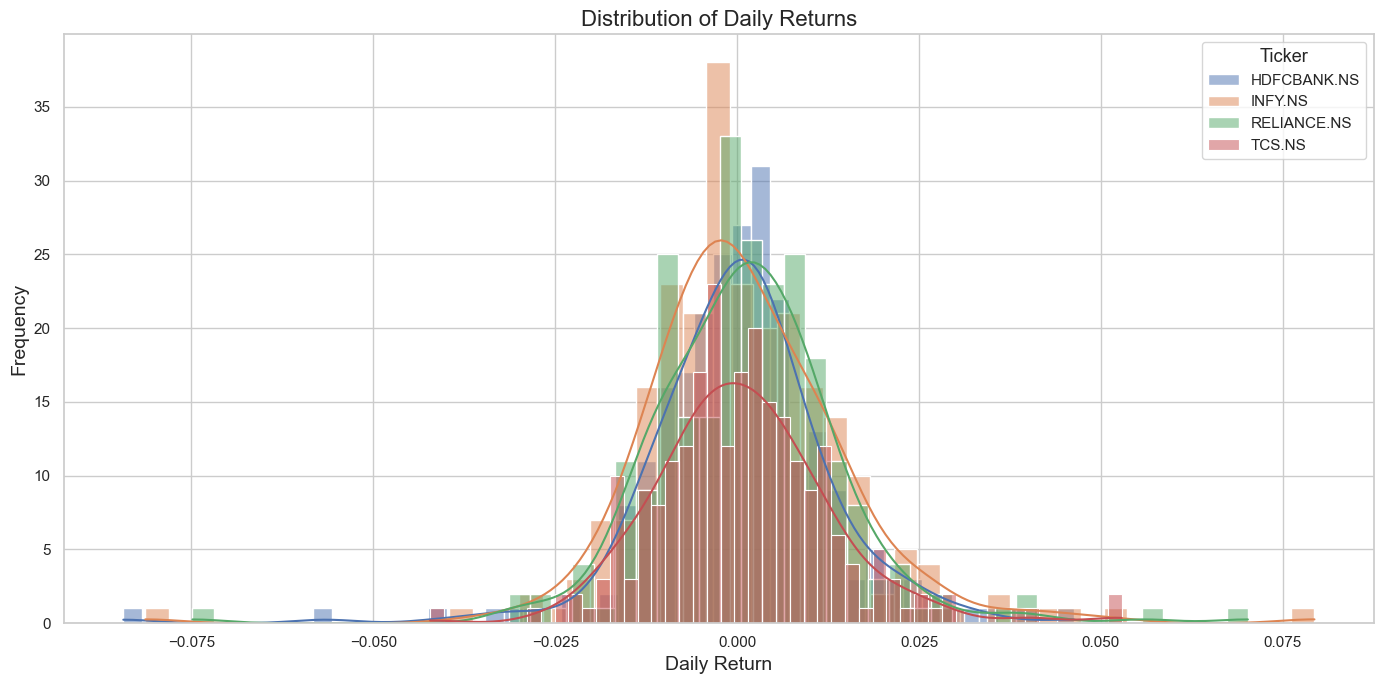

In [26]:
df['Daily_Return'] = df.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14,7))
sns.set(style='whitegrid')

for ticker in df_tickers:
    ticker_data = df[df['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily_Return'].dropna(), bins =50, kde= True, label = ticker, alpha =0.5)

    plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
df['Daily Return']

Date
2023-07-03         NaN
2023-07-03         NaN
2023-07-03         NaN
2023-07-03         NaN
2023-07-04    0.004884
                ...   
2024-06-27    0.020307
2024-06-28   -0.007281
2024-06-28   -0.004195
2024-06-28    0.022770
2024-06-28   -0.007626
Name: Daily Return, Length: 972, dtype: float64

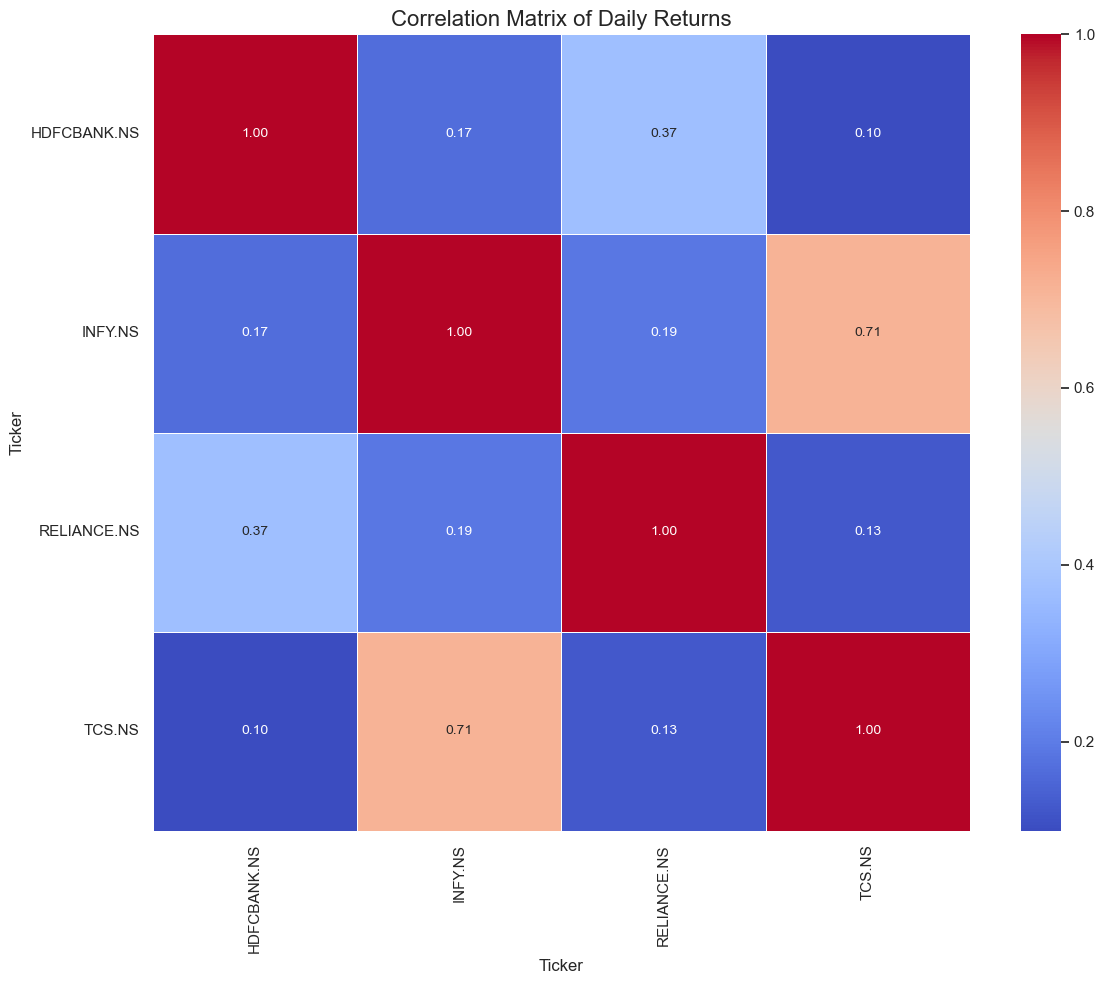

In [ ]:
daily_returns = df.pivot_table(index= 'Date', columns= 'Ticker', values = 'Daily Return')
corr_mat = daily_returns.corr()

plt.figure(figsize=(12,10))
sns.set(style='whitegrid')

sns.heatmap(corr_mat, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize = 16)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()


In [31]:
expected_returns = daily_returns.mean()*252
volatility = daily_returns.std() * np.sqrt(252)

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.013661,0.206910
INFY.NS,0.213798,0.232261
RELIANCE.NS,0.297343,0.214664
TCS.NS,0.220852,0.196869


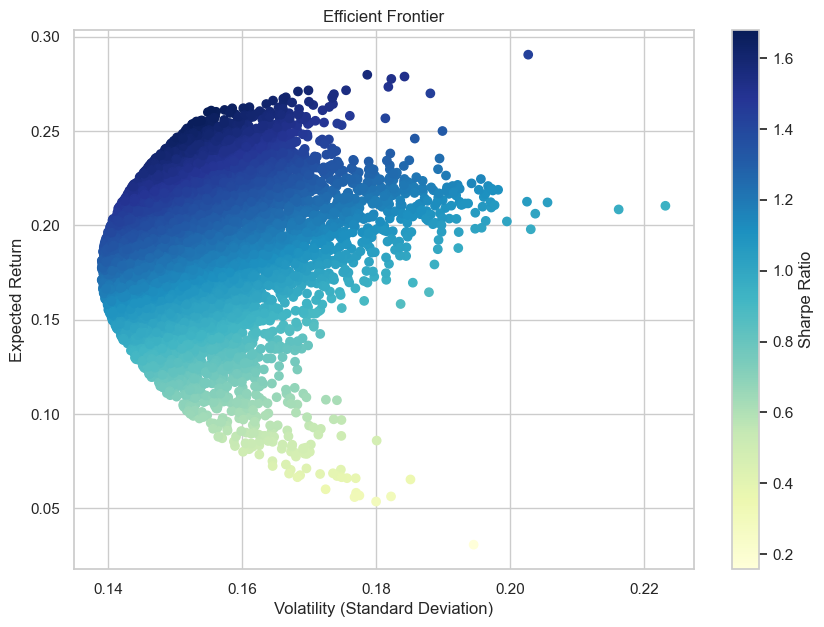

In [34]:
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatality = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatality

num_portfolios = 10000

results = np.zeros((3, num_portfolios))

cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(df_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns,cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return/portfolio_volatility

plt.figure(figsize=(10,7))
plt.scatter(results[1,:], results[0,:], c= results[2,:], cmap='YlGnBu', marker='o' )
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [35]:
max_sharpee_idx = np.argmax(results[2])
max_sharpee_return = results[0, max_sharpee_idx]
max_sharpee_volatility = results[1, max_sharpee_idx]
max_sharpee_ratio = results[2, max_sharpee_idx]

max_sharpee_return, max_sharpee_volatility, max_sharpee_ratio

(0.26076539462645376, 0.15535419837197528, 1.6785217094814855)

In [37]:
max_sharpee_weights = np.zeros(len(df_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(df_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpee_ratio:
        max_sharpee_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': df_tickers,
    'Weight': max_sharpee_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.150016
1,INFY.NS,0.135278
2,RELIANCE.NS,0.337379
3,TCS.NS,0.377326
